# Filtering a Preexisting Trajectory or Data Series

In some cases, there is no need to perform control based on the particle belief and instead the goal is to filter a previously-generated sequence of measurements to remove noise or reconstruct hidden state variables. This tutorial will illustrate use of the `runfilter` function for that purpose.

In [1]:
using Distributions
using Random
using DelimitedFiles
using ParticleFilters
using Plots

## Model

We will use [Euler-integrated](https://en.wikipedia.org/wiki/Euler_method) [Van Der Pol Oscillator Equations](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator) with noise added as the dynamics (`f`), and measurements of the position with gaussian noise added (the pdf is encoded in `g`).

This model is implemented below. For more information on defining models for particle filters, see the documentation [TODO: add link].

In [2]:
const dt = 0.2
const mu = 0.8
const sigma = 1.0

function f(x, u, rng)
    xdot = [x[2], mu*(1-x[1]^2)*x[2] - x[1] + u + 0.1*randn(rng)]
    return x + dt*xdot
end

g(x1, u, x2, y) = pdf(Normal(sigma), y-x2[1])

m = ParticleFilterModel{Vector{Float64}}(f, g);

## Data

Suppose that the data we would like to filter are contained in text files. [`u.txt`](u.txt) contains the control inputs, and [`y.txt`](y.txt) contains the measurements. The code that generated this data can be found in the [appendix below](#Appendix).

In [3]:
ys = vec(readdlm("y.txt"))
us = vec(readdlm("u.txt"));

## Filtering

We can use a particle filter to get a better estimate of the state. Note that we start with an initial belief consisting of particles with zero velocity and position uniformly distributed in $[-5, 5]$.

In [4]:
n = 10000
fil = BootstrapFilter(m, n)

# construct initial belief
b0 = ParticleCollection([[10.0*(rand()-0.5), 0.0] for i in 1:n])

bs = runfilter(fil, b0, us, ys);

## Plotting the Results

We can now plot the observations, the smoothed estimate of the position (the mean of the belief at every time step), and the true state. Note that the estimated position is much closer to the true position than the noisy measurements.

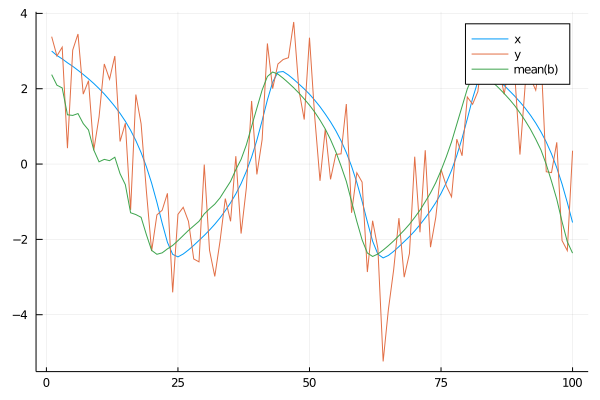

In [5]:
xmat = readdlm("x.txt")
xs = [xmat[i,:] for i in 1:size(xmat, 1)]

plot([first(xk) for xk in xs], label="x")
plot!(ys, label="y")
plot!([first(m) for m in map(mean, bs)], label="mean(b)")


## Appendix


### Code for Generating Data

The following code can be used to generate the data in the text files:

```julia
rng = MersenneTwister(1)

k = 100
h(x, rng) = x[1] + sigma*randn(rng)

x = [3.0, 0.0]
xs = Array{typeof(x)}(undef, k)
us = zeros(k)
ys = zeros(k)
for t in 1:k
    x = f(x, us[t], rng)
    ys[t] = h(x, rng)
    xs[t] = x
end

using DelimitedFiles
writedlm("x.txt", xs)
writedlm("y.txt", ys)
writedlm("u.txt", us)
```